In [1]:
# 導入必要的庫
import pandas as pd
import json
from datetime import timedelta

# 讀取 JSON 檔案
file_path = '/Users/chianlee/Desktop/disney/data/testing_data_sea.json'
file_path_names = '/Users/chianlee/Desktop/disney/data/sea_namelist.json'

with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with open(file_path_names, 'r', encoding='utf-8') as file:
    names = json.load(file)

# 轉換為 DataFrame
df_data = pd.DataFrame(data)
df_names = pd.DataFrame(names)

# 刪除 'FacilityName' 欄位並移除 'StandbyTime' 為 null 的行
df_data = df_data.drop(columns=['FacilityName'])
df_data = df_data[df_data['StandbyTime'].notna()]
df_data = df_data[df_data['StandbyTime'] != False]

# 解析日期時間欄位
df_data['UpdateTime'] = pd.to_datetime(df_data['UpdateTime'], format='%H:%M')
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

# 將所有 datetime 欄位加上一小時
df_data['datetime'] = df_data['datetime'] + pd.Timedelta(hours=1)

# 提取日期並應用於 UpdateTime
df_data['UpdateTime'] = df_data.apply(
    lambda row: row['UpdateTime'].replace(year=row['datetime'].year, month=row['datetime'].month, day=row['datetime'].day),
    axis=1
)

# 計算 UpdateTime 和 datetime 之間的時間差（以小時為單位）
df_data['time_difference'] = (df_data['datetime'] - df_data['UpdateTime'])

# 刪除時間差超過2小時的資料
df_filtered = df_data[df_data['time_difference'] <= timedelta(hours=2)]

# 刪除多餘的時間差欄位
df_filtered = df_filtered.drop(columns=['time_difference'])

df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

# 將 StandbyTime 轉換為數值型，並處理無法轉換的值
df_filtered['StandbyTime'] = pd.to_numeric(df_filtered['StandbyTime'], errors='coerce')

# 將 NaN 值轉換為 0
df_filtered['StandbyTime'] = df_filtered['StandbyTime'].fillna(0)

#設索引
df_filtered.set_index('datetime', inplace=True)

# 提取設施名稱和小時
df_filtered['Hour'] = df_filtered.index.hour

# 篩選 8 點到 20 點之間的數據
df_filtered = df_filtered[(df_filtered['Hour'] >= 8) & (df_filtered['Hour'] <= 20)]

In [2]:
# 1. 對 StandbyTime 進行15分鐘重取樣並計算平均值
df_resampled = df_filtered.groupby('FacilityID').resample('15min').agg({'StandbyTime': 'mean'}).reset_index()

# 2. 合併數據框以添加英文設施名稱
df_resampled = df_resampled.merge(df_names[['FacilityID', 'FacilityEnglish']], on='FacilityID', how='left')

# 3. 創建一個空的 DataFrame 來儲存最終的結果
full_df = pd.DataFrame()

# 4. 獲取所有唯一的設施名稱
facilities = df_resampled['FacilityEnglish'].unique()

# 5. 遍歷每個設施
for facility in facilities:
    # 5.1 篩選出當前設施的數據
    facility_data = df_resampled[df_resampled['FacilityEnglish'] == facility].copy()
    
    # 5.2 設置 'datetime' 為索引
    facility_data.set_index('datetime', inplace=True)
    
    # 5.3 以15分鐘為單位重取樣
    # 5.4 進行線性插值
    facility_data_interpolated = facility_data.interpolate(method='linear')
    
    # 5.5 前向填充和後向填充
    facility_data_filled = facility_data_interpolated.ffill().bfill()
    
    # 5.6 重設索引以回到 DataFrame 格式
    facility_data_filled.reset_index(inplace=True)
    
    # 5.7 添加設施名稱欄位
    facility_data_filled['FacilityEnglish'] = facility
    
    # 5.8 將處理後的數據合併到最終結果中
    full_df = pd.concat([full_df, facility_data_filled], ignore_index=True)

# 將結果存成 JSON 格式
output_file_path = '/Users/chianlee/Desktop/disney/data/quarter_data.json'

# 轉換 DataFrame 為 JSON
full_df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

print(f"結果已保存到 {output_file_path}")

# # 顯示結果
# print(full_df)

結果已保存到 /Users/chianlee/Desktop/disney/quater_data.json


/var/folders/09/tx1npfh95h97ysj5tqsh00nc0000gn/T/ipykernel_8428/1977675105.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  facility_data_interpolated = facility_data.interpolate(method='linear')
/var/folders/09/tx1npfh95h97ysj5tqsh00nc0000gn/T/ipykernel_8428/1977675105.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  facility_data_interpolated = facility_data.interpolate(method='linear')
/var/folders/09/tx1npfh95h97ysj5tqsh00nc0000gn/T/ipykernel_8428/1977675105.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  facility_data_interpolated = facility_data.interpolate(method='linear')
/var/folders/09/tx1npf

In [5]:
#換算datetime
import datetime

# 給定的毫秒時間戳
timestamp_ms = 1722414600000

# 將毫秒時間戳轉換為秒時間戳
timestamp_s = timestamp_ms / 1000

# 轉換為 datetime 對象
dt = datetime.datetime.utcfromtimestamp(timestamp_s)

print(dt)

2024-07-31 08:30:00


In [ ]:
# 對 StandbyTime 進行重取樣並計算平均值
df_resampled = df_filtered.groupby('FacilityID').resample('15min').agg({'StandbyTime': 'mean'}).reset_index()

# 合併數據框以添加英文設施名稱
df_resampled = df_resampled.merge(df_names[['FacilityID', 'FacilityEnglish']], on='FacilityID', how='left')

# 顯示結果
print(df_resampled)

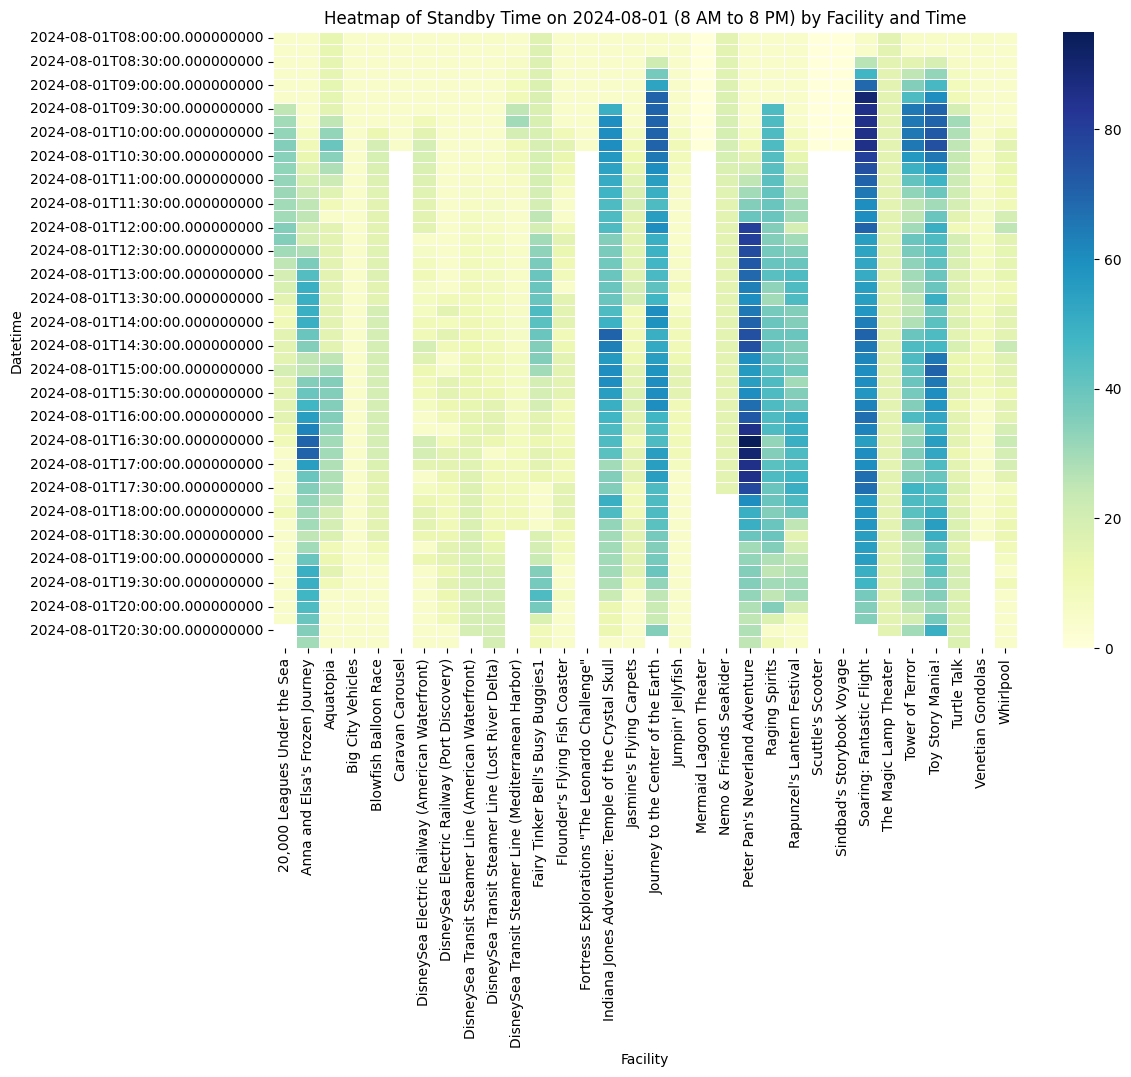

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假設 full_df 已經是處理後的 DataFrame

# 1. 轉換 datetime 到日期和時間
full_df['date'] = full_df['datetime'].dt.date
full_df['hour'] = full_df['datetime'].dt.hour

# 2. 過濾出 8 月 1 日的數據
date_of_interest = pd.to_datetime('2024-08-01').date()
filtered_df = full_df[full_df['date'] == date_of_interest]

# 3. 篩選出早上 8 點到晚上 8 點之間的數據
filtered_df = filtered_df[(filtered_df['hour'] >= 8) & (filtered_df['hour'] <= 20)]

# 4. 將 DataFrame 透視化
pivot_table = filtered_df.pivot_table(index='datetime', columns='FacilityEnglish', values='StandbyTime', aggfunc='mean')

# 5. 畫出熱力圖
plt.figure(figsize=(12, 8))  # 設置圖形大小
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False, cbar=True, linewidths=0.5)

# 設置圖形標題和標籤
plt.title('Heatmap of Standby Time on 2024-08-01 (8 AM to 8 PM) by Facility and Time')
plt.xlabel('Facility')
plt.ylabel('Datetime')

# 顯示圖形
plt.show()


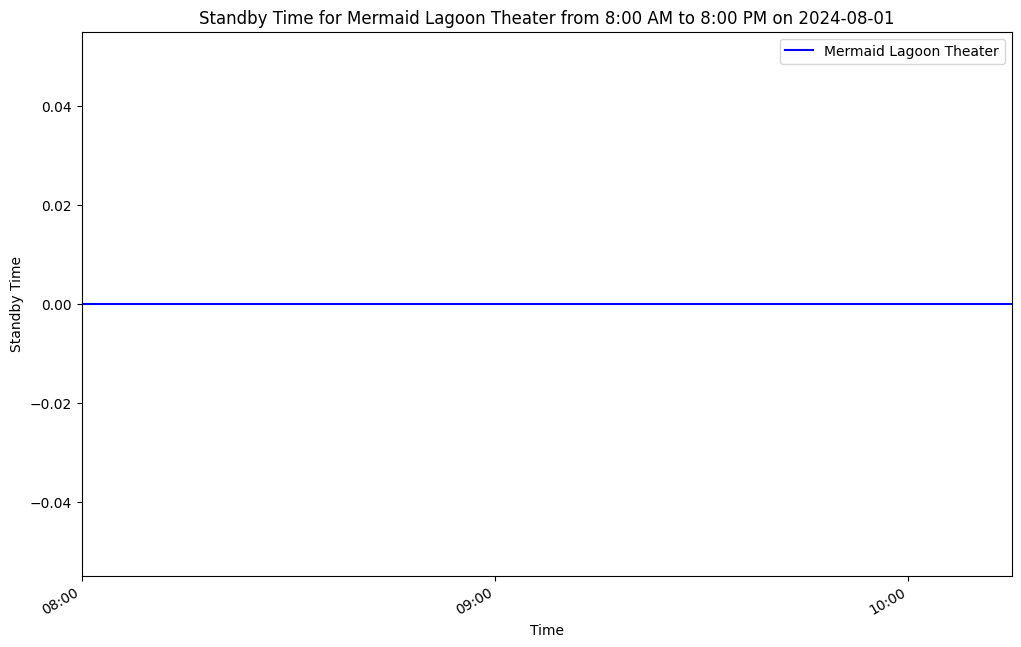

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 full_df 是處理後的 DataFrame

# 1. 轉換 datetime 到日期和時間
full_df['date'] = full_df['datetime'].dt.date
full_df['hour'] = full_df['datetime'].dt.hour

# 2. 過濾出 8 月 1 日的數據
date_of_interest = pd.to_datetime('2024-08-01').date()
filtered_df = full_df[full_df['date'] == date_of_interest]

# 3. 篩選出早上 8 點到晚上 8 點之間的數據
filtered_df = filtered_df[(filtered_df['hour'] >= 8) & (filtered_df['hour'] <= 20)]

# 4. 只顯示 'Mermaid Lagoon Theater' 設施的數據
facility_of_interest = 'Mermaid Lagoon Theater'
facility_data = filtered_df[filtered_df['FacilityEnglish'] == facility_of_interest]

# 5. 繪製折線圖
plt.figure(figsize=(12, 8))  # 設置圖形大小
plt.plot(facility_data['datetime'], facility_data['StandbyTime'], label=facility_of_interest, color='b')

# 設置圖形標題和標籤
plt.title(f'Standby Time for {facility_of_interest} from 8:00 AM to 8:00 PM on 2024-08-01')
plt.xlabel('Time')
plt.ylabel('Standby Time')
plt.legend()

# 設置 x 軸顯示整個時間範圍
plt.xlim([facility_data['datetime'].min(), facility_data['datetime'].max()])

# 格式化 x 軸日期時間顯示
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))

# 自動調整日期標籤
plt.gcf().autofmt_xdate()

# 顯示圖形
plt.show()
